In [1]:
!pip install eli5==0.13.0

# 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 56 not upgraded.


In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns
# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

from sklearn.preprocessing import MinMaxScaler
#standardscaler
from sklearn.preprocessing import StandardScaler
#robustscaler
from sklearn.preprocessing import RobustScaler

In [2]:
#샘플 데이터 불러오기
house_train = pd.read_csv("/root/datas/data/train.csv")
house_test = pd.read_csv("/root/datas/data/test.csv")

In [4]:
numeric_features = house_train.select_dtypes(include=[np.number]).columns
categorical_features = house_train.select_dtypes(include=[np.object]).columns

In [5]:
print(numeric_features)
print(categorical_features)

Index(['본번', '부번', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도', '해제사유발생일',
       '단지소개기존clob', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-135㎡초과', '건축면적', '주차대수', '좌표X', '좌표Y', 'target'],
      dtype='object')
Index(['시군구', '번지', '아파트명', '도로명', '등기신청일자', '거래유형', '중개사소재지',
       'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식',
       'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일'],
      dtype='object')


In [4]:
house_train.head(2)

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,123500


# 탐색 전 전처리


### 결측치 90%이상인 feature 제거

In [6]:
# 결측치 비율 계산
missing_ratio = (house_train.isnull().sum() / len(house_train)) * 100
columns_to_drop = missing_ratio[missing_ratio > 90].index.tolist()
columns_to_drop.pop(2)
print(columns_to_drop)

print("삭제할 컬럼들 (결측치 90% 이상):")
for col in columns_to_drop:
    print(f"- {col}: {missing_ratio[col]:.2f}%")

house = house_train.drop(columns=columns_to_drop)

house.info()

['해제사유발생일', '단지소개기존clob', 'k-등록일자']
삭제할 컬럼들 (결측치 90% 이상):
- 해제사유발생일: 99.47%
- 단지소개기존clob: 93.87%
- k-등록일자: 99.02%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 49 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1118822 non-null  object 
 1   번지                      1118597 non-null  object 
 2   본번                      1118747 non-null  float64
 3   부번                      1118747 non-null  float64
 4   아파트명                    1116696 non-null  object 
 5   전용면적(㎡)                 1118822 non-null  float64
 6   계약년월                    1118822 non-null  int64  
 7   계약일                     1118822 non-null  int64  
 8   층                       1118822 non-null  int64  
 9   건축년도                    1118822 non-null  int64  
 10  도로명                     1118822 non-null  object 
 11  등기신청일자                  1118822 non-null  object 
 12

## 본번과 부번 문자열로 전환 및 변수이름 재정의

In [7]:
# 본번, 부번 문자열로 변환
house['본번'] = house['본번'].astype(str)
house['부번'] = house['부번'].astype(str)
numeric_features = house.select_dtypes(include=[np.number]).columns
categorical_features = house.select_dtypes(include=[np.object]).columns

print(numeric_features)
print(categorical_features)


Index(['전용면적(㎡)', '계약년월', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적',
       'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)',
       'k-85㎡~135㎡이하', 'k-135㎡초과', '건축면적', '주차대수', '좌표X', '좌표Y', 'target'],
      dtype='object')
Index(['시군구', '번지', '본번', '부번', '아파트명', '도로명', '등기신청일자', '거래유형', '중개사소재지',
       'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식',
       'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-홈페이지',
       'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일'],
      dtype='object')


In [8]:
cols = list(house.columns)
cols[5] = '전용면적'
#열들 중에 앞에 "k-"가 붙은 열들은 "k-" 제거
cols = [col.replace('k-', '') for col in cols]
house.columns = cols

# 수치형 변수 탐색

### 군 구에 따른 집값 분포

In [12]:
print(house['시군구'].isnull().sum()) # 결측치 없음

#시군구 데이터에서 "시 군 구" 형식이 모두 맞는지 확인
house_check = house['시군구'].str.split(' ').str.len()
print(house_check.value_counts()) # 모두 3개의 문자열로 이루어져 있음

# 시군구 데이터에서 시, 군, 구 분리
# 데이터 자체가 서울시 데이터이므로 시 데이터는 제외
house['구'] = house['시군구'].str.split(' ').str[1]
house['동'] = house['시군구'].str.split(' ').str[2]
house.head(2)


0
3    1118822
Name: 시군구, dtype: int64


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,팩스번호_유무,전화번호_유무,구,동
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000,1,1,강남구,개포동
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,123500,1,1,강남구,개포동


In [13]:
print(house['구'].value_counts())
print(house['동'].value_counts())

# 군 데이터에서 결측치 확인
print(house['구'].isnull().sum())
print(house['동'].isnull().sum())


노원구     115099
송파구      73785
강남구      69083
강서구      66610
강동구      61895
구로구      57604
성북구      56675
양천구      53977
서초구      53126
도봉구      52572
영등포구     47640
동작구      40507
마포구      40387
동대문구     39693
성동구      39358
은평구      38283
중랑구      37094
관악구      35967
서대문구     32875
광진구      22070
강북구      21896
용산구      20551
금천구      19586
중구       13388
종로구       9101
Name: 구, dtype: int64
상계동     44948
중계동     26357
신정동     24038
창동      23101
구로동     22811
        ...  
필동1가        6
주성동         5
연지동         4
구수동         3
입정동         1
Name: 동, Length: 337, dtype: int64
0
0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


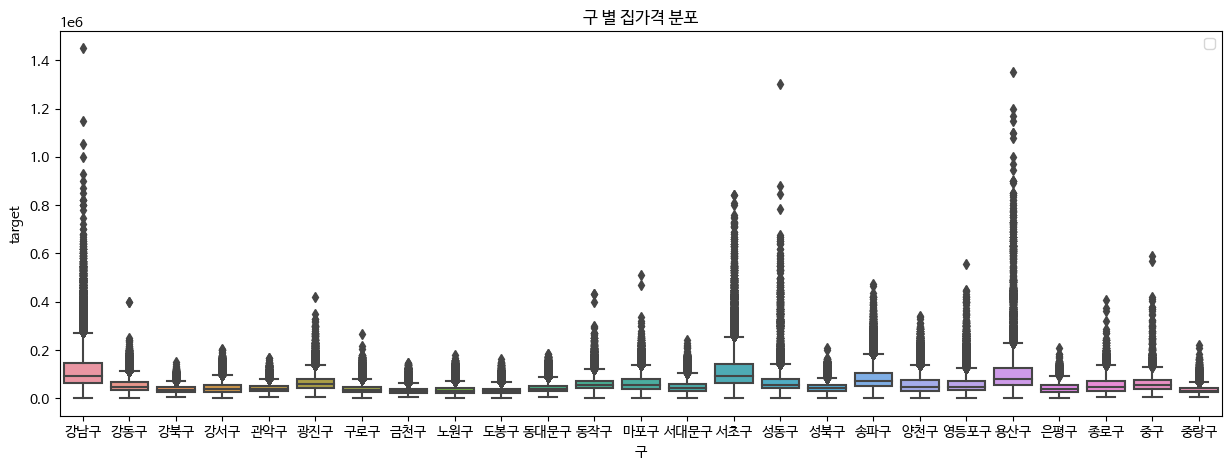

In [14]:
#구 별로 집가격 분포 확인
plt.figure(figsize=(15, 5))
sns.boxplot(data=house, x='구', y='target')

plt.legend(loc='upper right')
plt.title('구 별 집가격 분포')
plt.show()

# # 동 별로 집가격 평균, 중앙값 확인
# print(house.groupby('동')['target'].mean())
# print(house.groupby('동')['target'].median())

우선 집값이 높은 구들은 강남구, 서초구, 성동구, 용산구 등이 있다. 이번에는 이 높은 구들을 제외하고 다시 분포를 확인해보자
 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


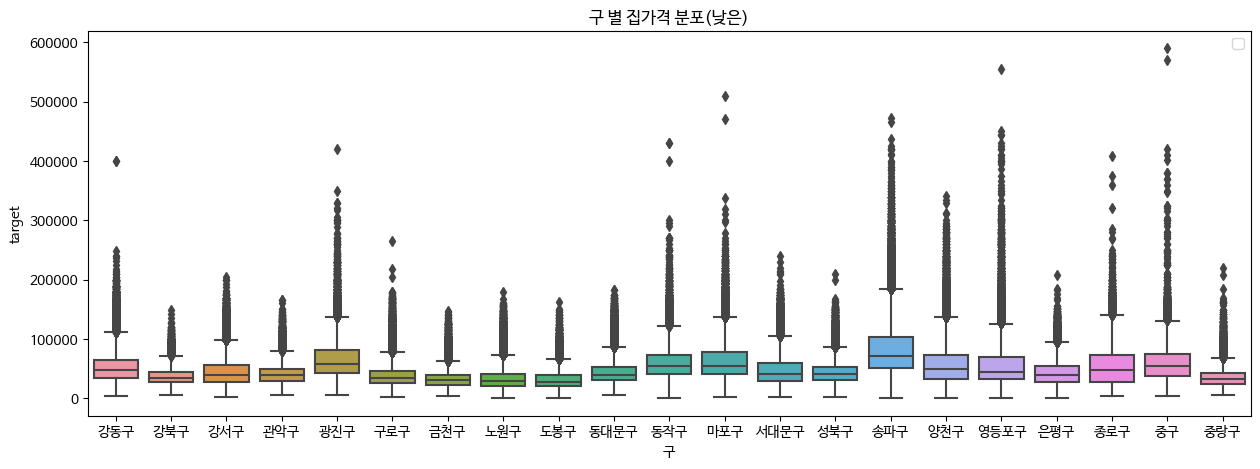

In [15]:
house_high = ['강남구', '서초구', '성동구', '용산구']

# 높은 구들을 제외한 구들의 집값 분포 확인
house_low = house[~house['구'].isin(house_high)]

plt.figure(figsize=(15, 5))
sns.boxplot(data=house_low, x='구', y='target')

plt.legend(loc='upper right')
plt.title('구 별 집가격 분포(낮은)')
plt.show()

약간씩의 차이는 보이지만 등급을 나누기는 힘들어보인다. 그나마 뚜렷해보이는 건 송파구.

### numeric value 상관관계 분석

                         전용면적(㎡)      계약년월       계약일         층      건축년도  \
전용면적(㎡)                 1.000000  0.027772  0.003779  0.103043  0.077800   
계약년월                    0.027772  1.000000  0.007407  0.049182  0.163895   
계약일                     0.003779  0.007407  1.000000  0.001685  0.003002   
층                       0.103043  0.049182  0.001685  1.000000  0.190674   
건축년도                    0.077800  0.163895  0.003002  0.190674  1.000000   
k-전체동수                  0.013114 -0.001964  0.000316 -0.056793 -0.112887   
k-전체세대수                -0.041638  0.005142 -0.000095  0.011126 -0.189193   
k-연면적                   0.167118  0.041885  0.003487  0.106918  0.063101   
k-주거전용면적                0.151954  0.017978  0.001351  0.066612 -0.082714   
k-관리비부과면적               0.136666  0.023066  0.001127  0.072341 -0.065802   
k-전용면적별세대현황(60㎡이하)     -0.352161 -0.032039 -0.002448 -0.108475 -0.304461   
k-전용면적별세대현황(60㎡~85㎡이하)  0.084654  0.030042  0.001233  0.080472 -0.009125   
k-85㎡~135㎡이하

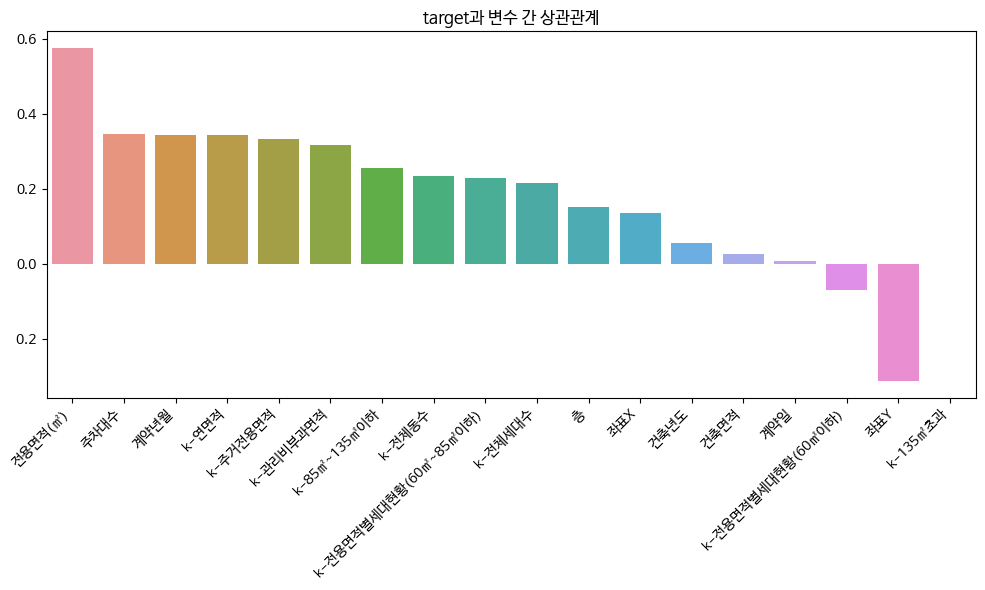


target과의 상관관계:
target: 1.0000
전용면적(㎡): 0.5770
주차대수: 0.3481
계약년월: 0.3447
k-연면적: 0.3436
k-주거전용면적: 0.3341
k-관리비부과면적: 0.3168
k-85㎡~135㎡이하: 0.2571
k-전체동수: 0.2345
k-전용면적별세대현황(60㎡~85㎡이하): 0.2296
k-전체세대수: 0.2175
층: 0.1532
좌표X: 0.1355
건축년도: 0.0560
건축면적: 0.0263
계약일: 0.0093
k-전용면적별세대현황(60㎡이하): -0.0690
좌표Y: -0.3122
k-135㎡초과: nan


In [16]:
def analyze_target_correlation(data: pd.DataFrame, target_col: str, numeric_features: np.array) -> None:

    # target과의 상관관계 계산
    correlation_matrix = data[numeric_features].corr()
    target_correlation = correlation_matrix[target_col].sort_values(ascending=False)
    print(correlation_matrix)

    # 상관관계가 높은 상위 변수들 시각화
    plt.figure(figsize=(10, 6))
    sns.barplot(x=target_correlation[1:].index, y=target_correlation[1:].values)
    plt.title(f'{target_col}과 변수 간 상관관계')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # 상관관계 값 출력
    print(f"\n{target_col}과의 상관관계:")
    for feature, corr in target_correlation.items():
        print(f"{feature}: {corr:.4f}")


# target 변수명 (실제 데이터의 target 변수명으로 대체 필요)

target_col = 'target'

# 상관관계 분석 실행
# plot_correlation_heatmap(house, numeric_features)
analyze_target_correlation(house, target_col, numeric_features)
# plot_high_correlation_scatter(house, numeric_features)


#### 계약일은 상관관계가 매우 낮아서 제외해도 될 것같다.

### 계약년월 분석

계약년
2007     31969.883574
2008     39559.710447
2009     50162.794165
2010     49571.817532
2011     45494.878488
2012     44379.360554
2013     44318.094953
2014     45831.005509
2015     47739.739964
2016     53448.494413
2017     61972.300582
2018     65895.231486
2019     82215.074716
2020     84962.562901
2021    103053.294826
2022    100060.129278
2023    105019.238660
Name: target, dtype: float64


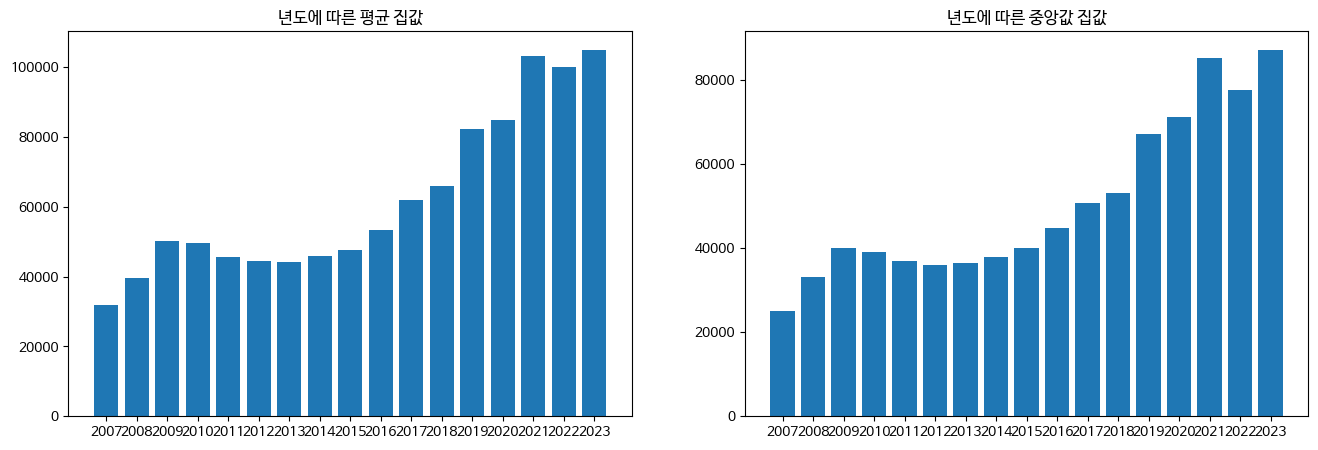

           계약년월  target   계약년 계약월
1118821  200701   13250  2007  01
1101889  200701   34300  2007  01
1101924  200701   55000  2007  01
1101925  200701   54800  2007  01
1101944  200701   34000  2007  01
...         ...     ...   ...  ..
217555   202306   78700  2023  06
205473   202306   63500  2023  06
211432   202306  125000  2023  06
217621   202306   68000  2023  06
205686   202306   84700  2023  06

[1118822 rows x 4 columns]


In [17]:
# print(house['계약년월'].isnull().sum())
# print(house['계약년월'].value_counts())

house_contract = house[['계약년월', 'target']].sort_values(by='계약년월')

# 계약년월 데이터에서 년도와 월 분리
house_contract['계약년'] = house_contract['계약년월'].astype(str).str[:4]
house_contract['계약월'] = house_contract['계약년월'].astype(str).str[4:]

# 년도별 집값 평균 계산
house_contract_mean = house_contract.groupby('계약년')['target'].mean()

# 년도별 집값 중앙값 계산
house_contract_median = house_contract.groupby('계약년')['target'].median()

print(house_contract_mean)

## histplot 그리기(년도에 따른 평균 집값)
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.bar(house_contract_mean.index, house_contract_mean.values)
plt.title('년도에 따른 평균 집값')
plt.subplot(1, 2, 2)
plt.bar(house_contract_median.index, house_contract_median.values)
plt.title('년도에 따른 중앙값 집값')
plt.show()


print(house_contract)



18년 -> 19년, 20년-> 21년 으로 넘어가는 시기에 유독 다른 시기보다 집값 상승이 가팔랐다. 중앙값도 평균값에 대체적으로 따라가는데 2022년도에 유독 평균값과 중앙값이 차이가 난다. 아웃라이어가 있을 것이다.

계약월
01    56327.400600
02    53689.325213
03    51798.815282
04    55393.842045
05    59465.539943
06    61716.415433
07    60760.184341
08    58664.546789
09    57828.887261
10    57629.529143
11    61605.765487
12    61728.808903
Name: target, dtype: float64
계약월
01    44000.0
02    42000.0
03    40000.0
04    42000.0
05    45300.0
06    48000.0
07    47500.0
08    45000.0
09    43600.0
10    45000.0
11    48000.0
12    47750.0
Name: target, dtype: float64


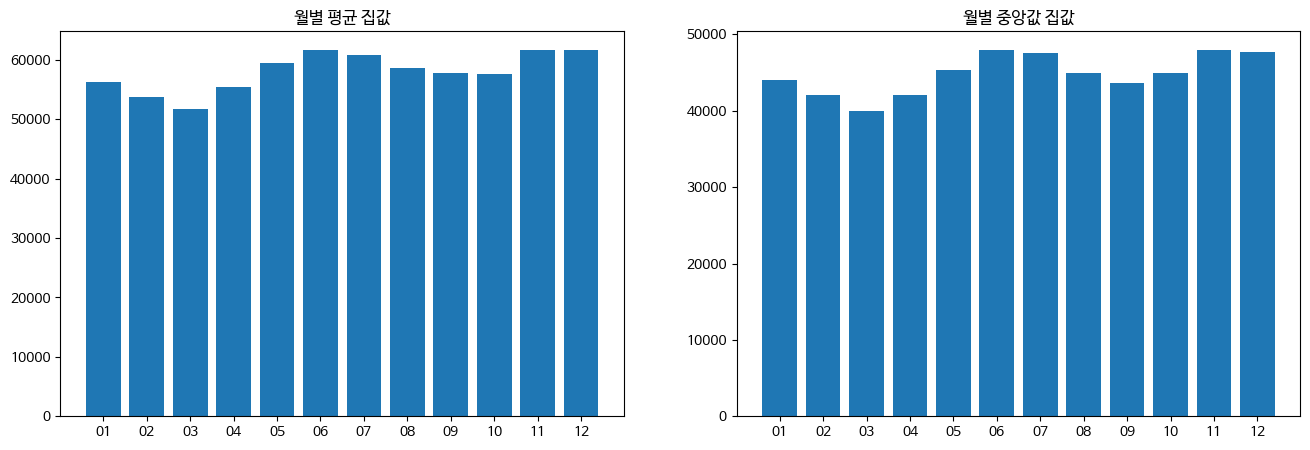

In [18]:
# 월별 집값 평균 계산
house_contract_mean = house_contract.groupby('계약월')['target'].mean()

# 월별 집값 중앙값 계산
house_contract_median = house_contract.groupby('계약월')['target'].median()

print(house_contract_mean)
print(house_contract_median)

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.bar(house_contract_mean.index, house_contract_mean.values)
plt.title('월별 평균 집값')
plt.subplot(1, 2, 2)
plt.bar(house_contract_median.index, house_contract_median.values)
plt.title('월별 중앙값 집값')
plt.show()


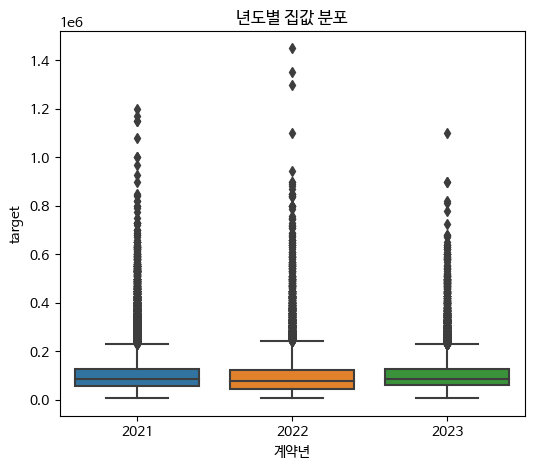

In [19]:
#21,22,23년도 boxplot 하나의 plot에 그리기
plt.figure(figsize=(6, 5))
# 계약년 중에서 21,22,23년도만 추출
house_contract_21 = house_contract[house_contract['계약년'].isin(['2021', '2022', '2023'])]
sns.boxplot(data=house_contract_21, x='계약년', y='target')
plt.title('년도별 집값 분포')
plt.show()







### 면적변수 분석(연면적, 주거전용면적, 관리비부과면적, 건축면적)

#### 요약

1. 연면적 > 관리비 부과 면적이면 추가시설 1, 아니면 0으로 해서 새로운 column 생성
2. 주거 전용 면적이 일정이상(200000~220000 정도)면 집값이 크게 분포되어 있음

#### 이전의 target간의 상관관계 분석에서 이 세 변수의 계수가 유사하게 나왔다. 이 세 변수 간의 상관관계를 파악하여 한 변수로 묶을 수 있지 않을까?

##### 각 변수의 의미
연면적: 건축물의 바닥면적을 모두 합한 것. 즉 총면적

주거전용면적: 일반적으로 사람들이 생활하는 공간의 면적

관리비부과면적: 보통 주택공급면적을 기준으로 관리비를 배분한다. 이때 주택 공급 면적은 주거 전용 면적(실내 공간), 주거 공용 면적(계단, 엘리베이터 등)을 더한 값이다. 예를 들어 주거 전용 면적이 $82m^{2}$이고 주거 공용 면적이 $32m^2$면 이 둘을 더한 $114m^2$ 만큼의 관리비를 부과한다.

건축면적: 수평투영면적, 건물이 대지면적 중에서 건물이 차지하는 면적

건축면적은 사실상 필요 없을 듯하다. 주거면적(세대), 주거전용면적(전체 세대)가 있으므로 건축면적은 이 두 변수와 겹치는 부분이 너무 많다. 집값과의 상관관계도 매우 낮았다. 

734781.0
   주거전용면적_구간         target
0          0   44574.445002
1      20000   59744.010302
2      40000   64926.156968
3      60000   68549.162457
4      80000   71387.556269
5     100000   89275.857600
6     120000   58617.009314
7     140000   62199.726746
8     160000   74337.897415
9     180000   55970.637437
10    200000   92178.768719
11    220000            NaN
12    240000   97506.691423
13    260000  123932.894038
14    280000  151311.578418
15    300000            NaN
16    320000            NaN
17    340000  123609.511710
18    360000            NaN
19    380000            NaN
20    400000  188633.028133
21    420000            NaN
22    440000            NaN
23    460000  118830.495046
24    480000            NaN
25    500000            NaN
26    520000  111547.059869
27    540000            NaN
28    560000            NaN
29    580000            NaN
30    600000            NaN
31    620000            NaN
32    640000            NaN
33    660000            NaN
34    68000

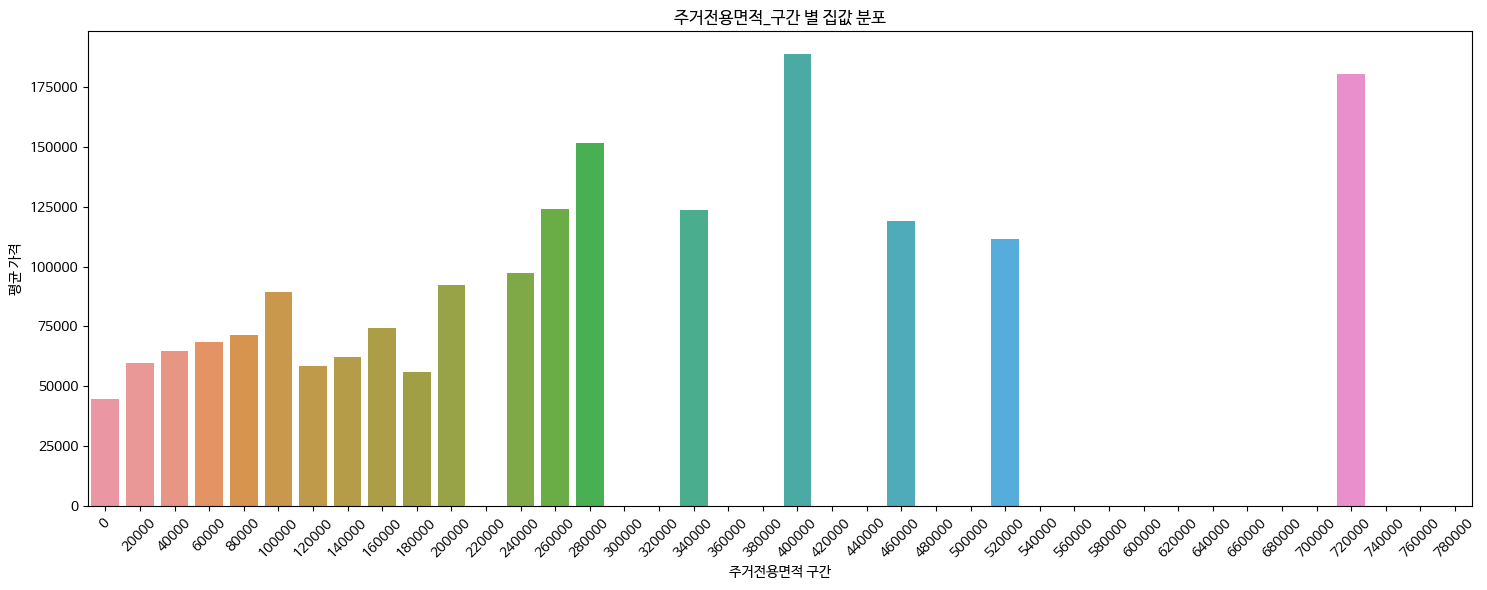

In [21]:
col_select = ['아파트명','전체세대수', '전용면적', '연면적', '주거전용면적', '관리비부과면적','건축면적', 'target']

# # 관리비 부과면적, 전체세대수 연면적의 결측치 확인
house_area = house.dropna(subset=['관리비부과면적', '연면적', '전체세대수'])
# print(house['전체세대수'].isnull().sum())
# print(house['관리비부과면적'].isnull().sum())
# print(house['연면적'].isnull().sum())
# print(len(house) - len(house_area))
# # 셋 간의 결측치 개수가 같다

# #주거 전용면적 분포 확인
# plt.figure(figsize=(10, 5))
# sns.histplot(house_area['주거전용면적'], bins=30, color='blue')
# plt.title('주거전용면적 분포')
# plt.show()

print(house_area['주거전용면적'].max())

#주거 전용 면적을 구간별로 나눠서 집값 분포를 확인(0에서부터 1000단위)
house_area['주거전용면적_구간'] = pd.cut(house_area['주거전용면적'], bins=range(0, 800001, 20000), labels=range(0, 800000, 20000))

#주거전용면적_구간 별 집값 평균 계산
house_area_mean = house_area.groupby('주거전용면적_구간')['target'].mean().reset_index()
print(house_area_mean)
#주거전용면적_구간 별 집값 중앙값 계산
house_area_median = house_area.groupby('주거전용면적_구간')['target'].median().reset_index()
print(house_area_median)

#히스토그램 그리기
plt.figure(figsize=(15, 6))
sns.barplot(x='주거전용면적_구간', y='target', data=house_area_mean)
plt.title('주거전용면적_구간 별 집값 분포')
plt.xlabel('주거전용면적 구간')
plt.ylabel('평균 가격')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()







# print(len(house_area))
# print(len(house_area.loc[house_area['연면적'] != house_area['관리비부과면적']]))
# print(house['전체세대수'].isnull().sum())
# print(house['주거전용면적'].isnull().sum())


# print(house_area.loc[house_area['연면적'] != house_area['관리비부과면적'],["연면적","관리비부과면적"]])
# print(house_area.loc[house_area['주거전용면적'].isnull()][col_select])
# print(house_area.loc[house_area['전체세대수'].isnull()][col_select])


# 아파트별 전용면적의 합이 주거 전용면적과 같은지 확인(아님)
# result = house_area.groupby("아파트명")['전용면적'].sum().reset_index()
# print(result.loc[result['아파트명'] == '개포6차우성'])

True     231052
False     18207
Name: 추가시설여부, dtype: int64
   추가시설여부        target
0   False  62366.154446
1    True  68944.380096
   추가시설여부   target
0   False  51000.0
1    True  53900.0


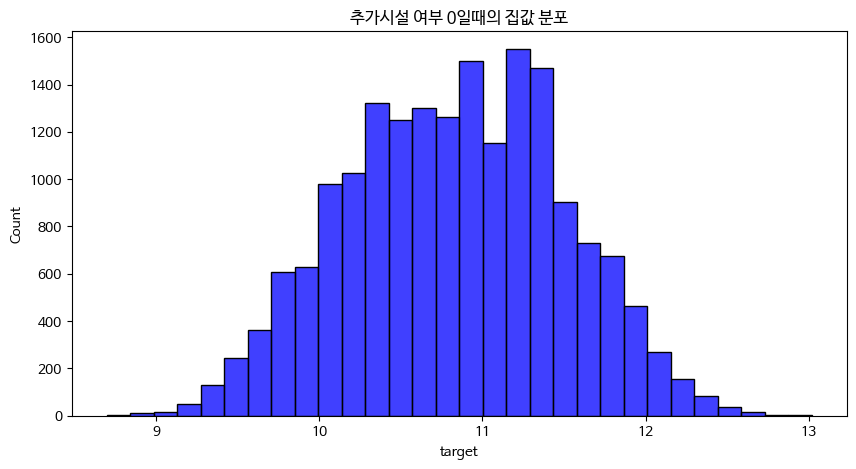

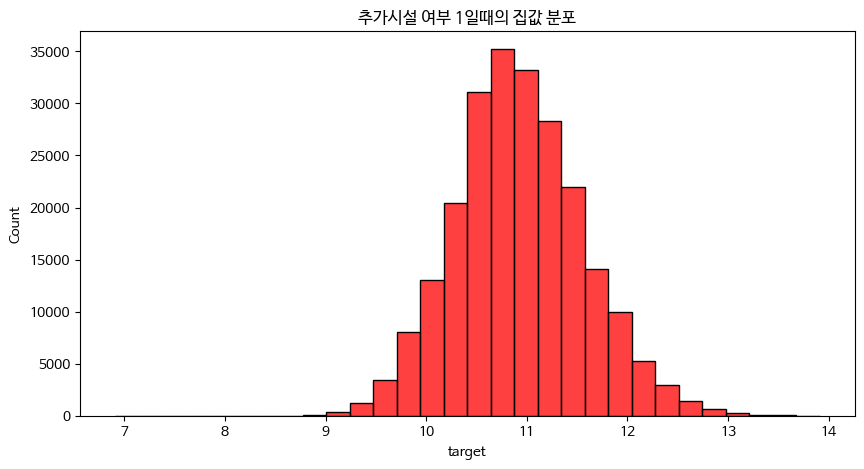

In [22]:
house_area['추가시설여부'] = house_area['연면적'] > house_area['관리비부과면적']
print(house_area['추가시설여부'].value_counts())

#추가시설여부 별 집값 평균 계산
house_area_mean = house_area.groupby('추가시설여부')['target'].mean().reset_index()
print(house_area_mean)

#추가시설여부 별 집값 중앙값 계산
house_area_median = house_area.groupby('추가시설여부')['target'].median().reset_index()
print(house_area_median)

#추가시설 여부 0일때의 집값 분포를 histplot으로 그리기
plt.figure(figsize=(10, 5))
sns.histplot(np.log1p(house_area[house_area['추가시설여부'] == 0]['target']), bins=30, color='blue')
plt.title('추가시설 여부 0일때의 집값 분포')
plt.show()

# 추가시설 여부 1일때의 집값 분포를 histplot으로 그리기
plt.figure(figsize=(10, 5))
sns.histplot(np.log1p(house_area[house_area['추가시설여부'] == 1]['target']), bins=30, color='red')
plt.title('추가시설 여부 1일때의 집값 분포')
plt.show()



### 면적 결측치 분석

#### 건축년도를 분석하는데, 이때 건축면적이 기입이 안된 데이터는 구축 건물일거라는 예상

0


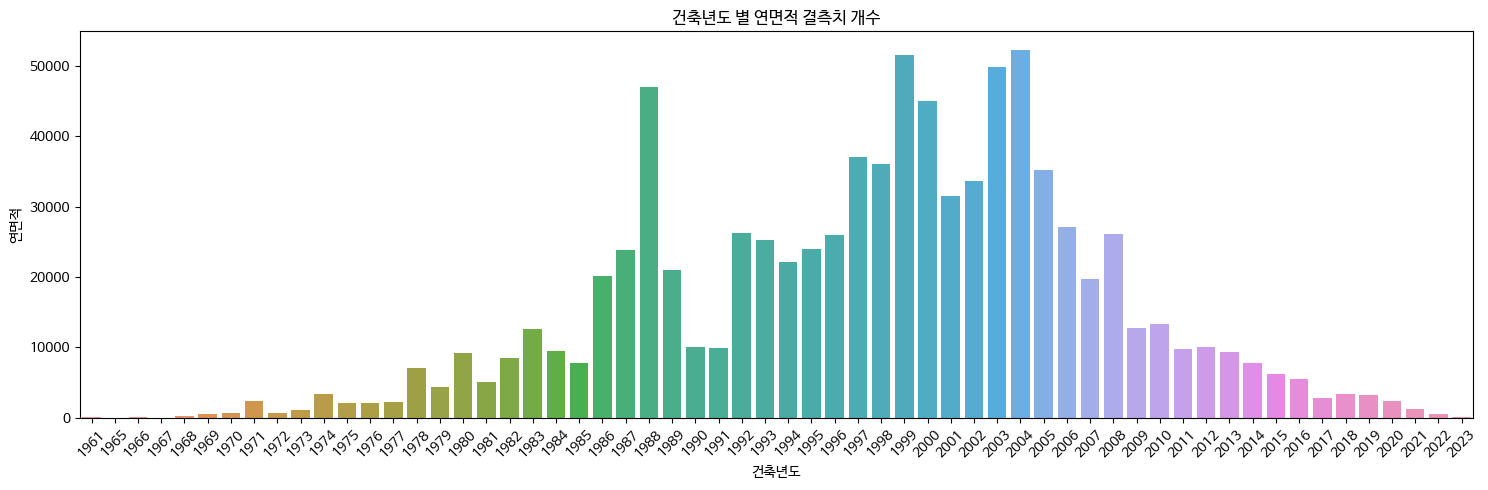

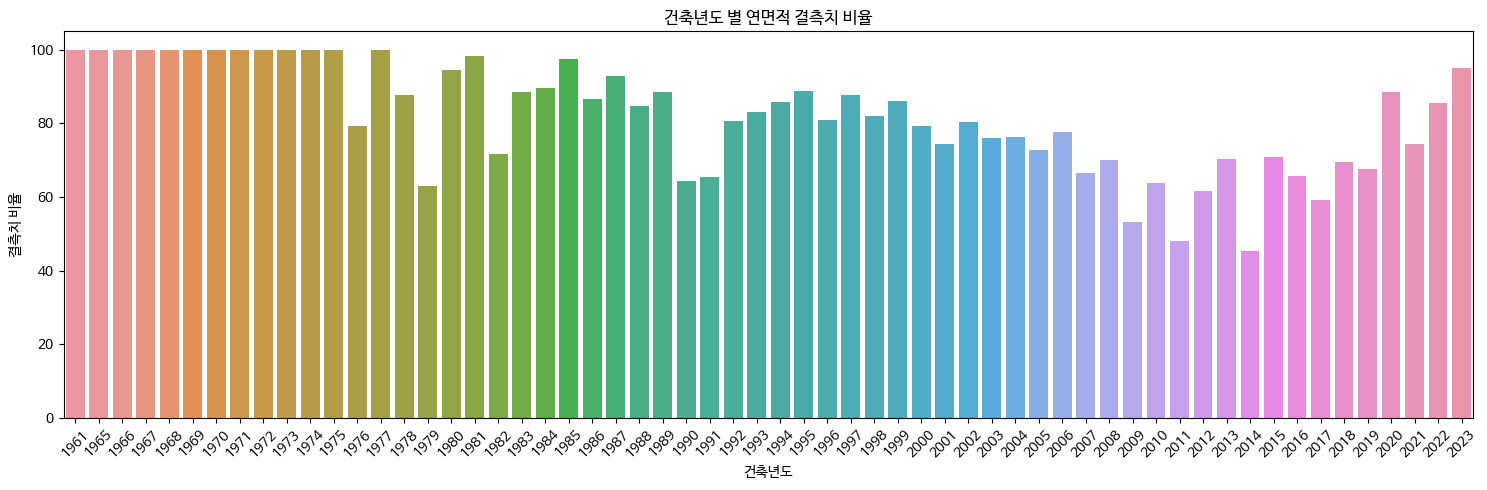

In [52]:
print(house['건축년도'].isnull().sum())

# 건축년도 별 연면적 결측치 개수 확인
# house_year = house['연면적'].isnull()
# display(house_year)

# 건축년도 별 연면적 결측치 개수 확인
house_year = house.groupby('건축년도')['연면적'].apply(lambda x: x.isnull().sum()).reset_index()
house_year['결측치 비율'] = round(house_year['연면적'] / house.groupby('건축년도')['연면적'].size().reset_index()['연면적'] * 100, 2)
plt.figure(figsize=(15, 5))
sns.barplot(x='건축년도', y='연면적', data=house_year)
plt.title('건축년도 별 연면적 결측치 개수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 건축년도 별 연면적 결측치 비율 확인
plt.figure(figsize=(15, 5))
sns.barplot(x='건축년도', y='결측치 비율', data=house_year)
plt.title('건축년도 별 연면적 결측치 비율')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



#### 아파트명 별로 그룹화하여 모든 면적 변수가 결측치인 것만 확인해보기

In [71]:
house_apart = house.groupby('아파트명')[['연면적', '주거전용면적']].apply(lambda x: x.notnull().any())
display(house_apart)

print(len(house_apart.loc[house_apart['연면적'] == False]))

,연면적,주거전용면적
아파트명,,
153-25,False,False
201호 미공시,False,False
2차한양,False,False
3RU-City,False,False
3차신성미소지움,False,False
...,...,...
힐탑트레져1동,False,False
힐튼,False,False
힐튼빌리지1차,False,False


5802


##### 결과적으로 5802개의 아파트가 모두 면적이 결측치이다.

#### 크기1,2,3,4(65, 80, 135)의 구간으로 나눠진 변수가 모두 비워져 있는 지 확인

##### 요약: 크기가 모두 적혀져 있지 않은 아파트가 5815개로 전체 6538개중 대다수를 차지한다.

In [72]:
house_cols = list(house.columns)
house_cols[29:33] = ['크기1', '크기2', '크기3', '크기4']
house.columns = house_cols
house[['크기1', '크기2', '크기3', '크기4']] = house[['크기1', '크기2', '크기3', '크기4']].fillna(0)

# 크기1, 크기2, 크기3, 크기4 중 하나라도 0이 아닌 경우 1, 모두 0인 경우 0으로 변환
house['크기_유무'] = house[['크기1', '크기2', '크기3', '크기4']].apply(lambda x: 1 if x.any() else 0, axis=1)



In [ ]:
house['크기_유무'].value_counts()
house_apart_size = house.groupby('아파트명')['크기_유무'].apply(lambda x: x.value_counts().get(1, 0)).reset_index()
display(house_apart_size)

print(len(house_apart_size.loc[house_apart_size['크기_유무'] == 0]))


,아파트명,크기_유무
0,153-25,0
1,201호 미공시,0
2,2차한양,0
3,3RU-City,0
4,3차신성미소지움,0
...,...,...
6533,힐탑트레져1동,0
6534,힐튼,0
6535,힐튼빌리지1차,0
6536,힐튼빌리지2차,0


5815


In [79]:
print(house['크기_유무'].sum())

print(house['크기_유무'].value_counts())

print(house['크기_유무'].isnull().sum())

print(house['연면적'].isnull().sum())



247785
0    871037
1    247785
Name: 크기_유무, dtype: int64
0
869563


### 다음 변수 분석

### 다음 변수

# 범주형 변수 탐색

In [121]:
# 변주형 변수 column 확인(dtype이 object인 것들)
object_columns = house.select_dtypes(include=['object']).columns
print(object_columns)

Index(['시군구', '번지', '본번', '부번', '아파트명', '도로명', '등기신청일자', '거래유형', '중개사소재지',
       '단지분류(아파트,주상복합등등)', '전화번호', '팩스번호', '세대타입(분양형태)', '관리방식', '복도유형',
       '난방방식', '건설사(시공사)', '시행사', '사용검사일-사용승인일', '홈페이지', '수정일자', '고용보험관리번호',
       '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일',
       '사용허가여부', '관리비 업로드', '단지신청일', '구', '동'],
      dtype='object')


### 거래유형에 따른 집값 차이

#### 요약: 거래 유형 변수는 집값 예측에 도움이 안 될 것 같다. 보통 사람들은 집값이 비싸면 거래 위험성을 줄이기 위해 중개 거래를 선호하는데 이것은 결과적 특성이지 집값을 결정하는 원인이 아니기 때문에 예측 변수에 넣으면 안 될 것 같다.

['-' '중개거래' '직거래']
0


-       1086451
중개거래      29271
직거래        3100
Name: 거래유형, dtype: int64

,아파트명,거래유형,target
0,개포6차우성,-,124000
1,개포6차우성,-,123500
2,개포6차우성,-,91500
3,개포6차우성,-,130000
4,개포6차우성,-,117000
...,...,...,...
1118817,갈현현대,-,20000
1118818,갈현현대,-,20000
1118819,갈현현대,-,28000
1118820,갈현현대,-,29000


   거래유형         target
0     -   56640.401515
1  중개거래  107599.854361
2   직거래   63105.090000


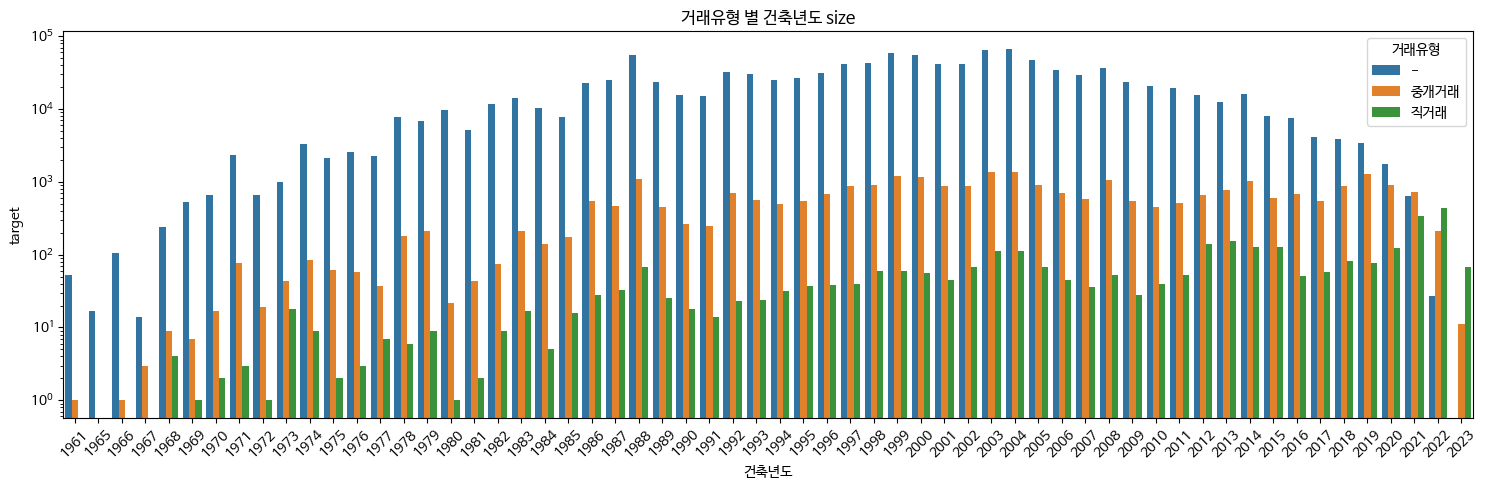

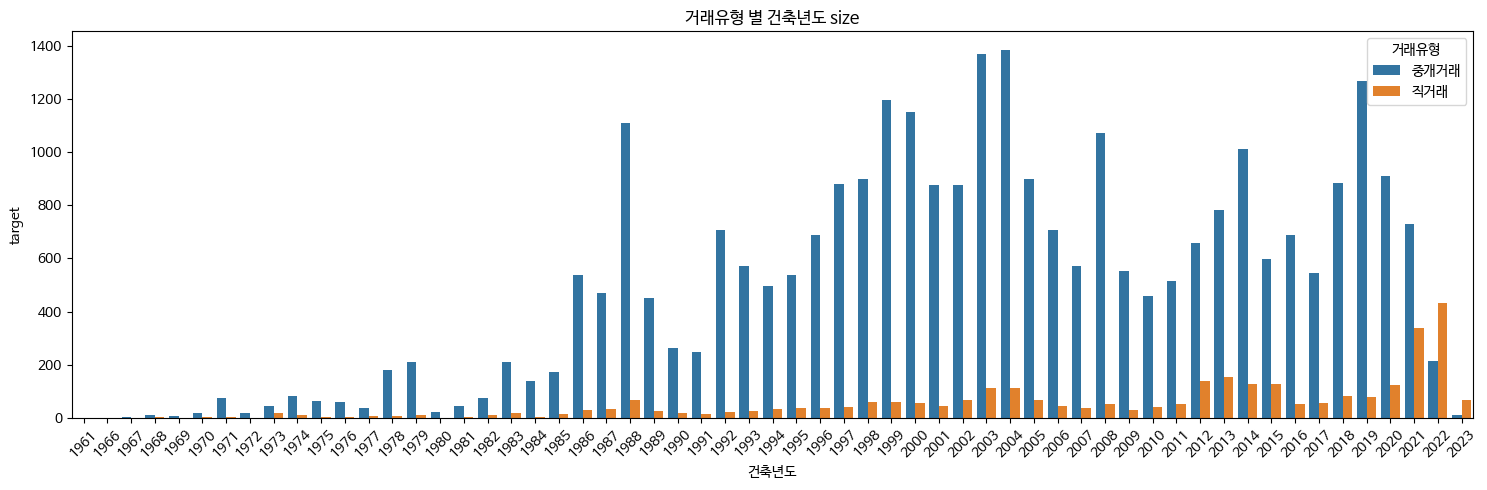

In [117]:
print(house['거래유형'].unique())
print(house['거래유형'].isnull().sum())
display(house['거래유형'].value_counts())
display(house[['아파트명', '거래유형', 'target']])


### 거래유형 별 집값 평균 계산
house_trade_mean = house.groupby('거래유형')['target'].mean().reset_index()
print(house_trade_mean)

### 거래유형 별 건축년도 size 확인
house_trade_year = house.groupby(['거래유형', '건축년도'])['target'].size().reset_index()
# display(house_trade_year)

house_trade_year2 = house_trade_year[house_trade_year['거래유형'] != '-']
# display(house_trade_year2)

### 거래유형 별 건축년도 size plot(y값은 log1p)
plt.figure(figsize=(15, 5))
sns.barplot(x='건축년도', y='target', hue='거래유형',  data=house_trade_year)
plt.yscale('log')
plt.title('거래유형 별 건축년도 size')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
sns.barplot(x='건축년도', y='target', hue='거래유형', data=house_trade_year2)
plt.title('거래유형 별 건축년도 size')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




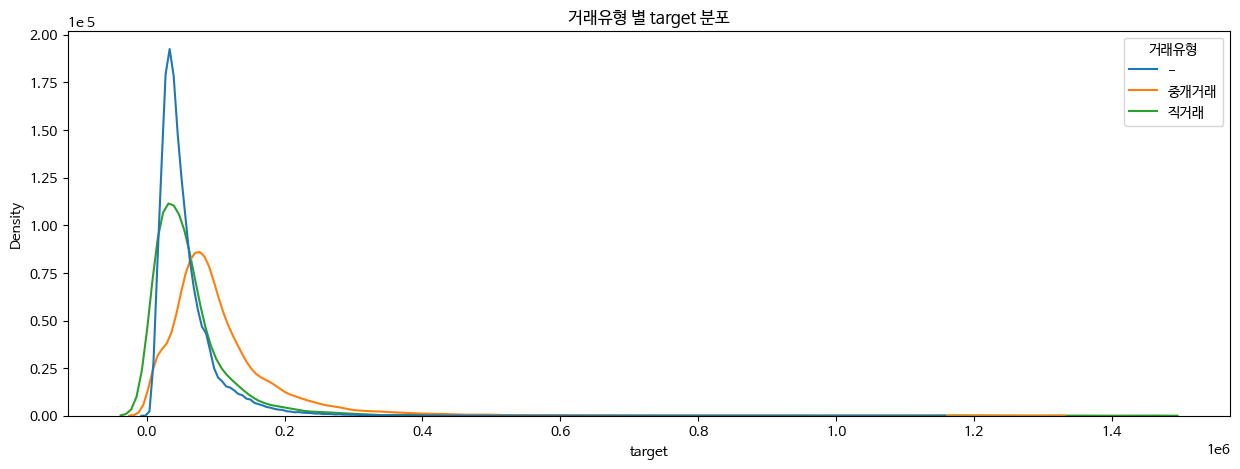

In [119]:
# 거래유형 별 target 분포를 kdeplot으로 그리기
plt.figure(figsize=(15, 5))
sns.kdeplot(x='target', hue='거래유형', data=house, common_norm=False)
plt.title('거래유형 별 target 분포')
plt.show()



### 팩스번호와 전화번호 유무에 따른 집값 차이 확인

#### 요약: 팩스 번호 유무 column을 만들어서 예측 변수로 활용하자

팩스번호 유무:  0    872742
1    246080
Name: 팩스번호_유무, dtype: int64
전화번호 유무:  0    870274
1    248548
Name: 전화번호_유무, dtype: int64


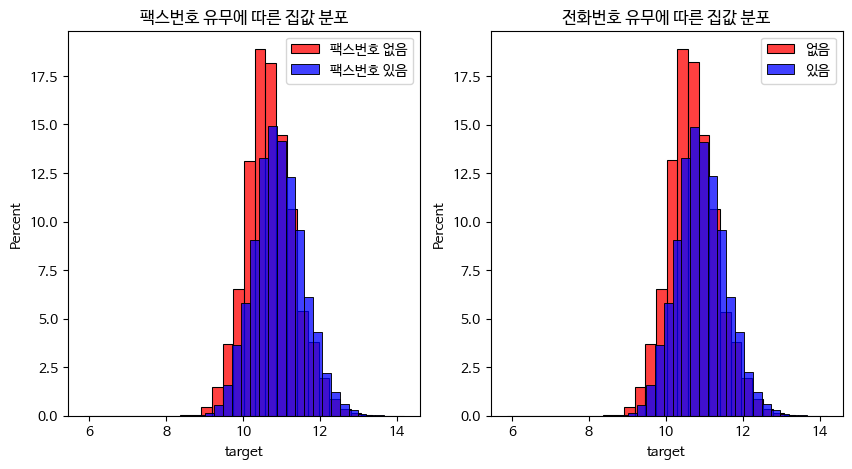

In [99]:
house['팩스번호_유무'] = house['팩스번호'].notnull().astype(int)
house['전화번호_유무'] = house['전화번호'].notnull().astype(int)

house.head(2)

print("팩스번호 유무: ", house['팩스번호_유무'].value_counts())
print("전화번호 유무: ", house['전화번호_유무'].value_counts())


### 팩스번호 유무에 따른 집값 분포 확인
fax_house = house[house['팩스번호_유무'] == 1]
non_fax_house = house[house['팩스번호_유무'] == 0]

fig, ax = plt.subplots(figsize=(10, 5), ncols=2, nrows=1)

sns.histplot(np.log1p(non_fax_house['target']), bins=30, color='red', label='팩스번호 없음', ax=ax[0], stat='percent')
sns.histplot(np.log1p(fax_house['target']), bins=30, color='blue', label='팩스번호 있음', ax=ax[0], stat='percent')

ax[0].legend(loc='upper right')
ax[0].set_title('팩스번호 유무에 따른 집값 분포')

### 전화번호 유무에 따른 집값 분포 확인
phone_house = house[house['전화번호_유무'] == 1]
non_phone_house = house[house['전화번호_유무'] == 0]

sns.histplot(np.log1p(non_phone_house['target']), bins=30, color='red', label='없음', ax=ax[1], stat='percent')
sns.histplot(np.log1p(phone_house['target']), bins=30, color='blue', label='있음', ax=ax[1], stat='percent')

ax[1].set_title('전화번호 유무에 따른 집값 분포')
ax[1].legend(loc='upper right')
plt.show()





#### 팩스번호, 전화번호 유무에 따른 집값의 분포가 거의 동일하다. 한 column은 없애도 될 것 같다.

이제 데이터의 유무가 실제로 집값에 얼마나 영향을 미치는지 확인해보자

팩스번호가 없을 때의 집값 평균과 중앙값:  54953.192908810146 42500.0
팩스번호가 있을 때의 집값 평균과 중앙값:  68439.41640117035 53600.0


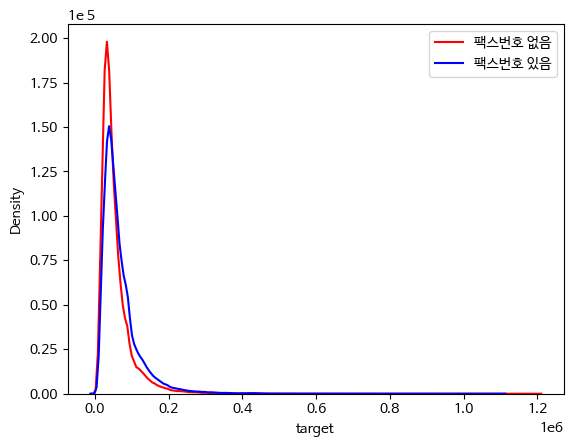

(array([6.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        1.2000e+01, 1.0500e+02, 4.5800e+02, 1.4780e+03, 4.2750e+03,
        8.6410e+03, 1.4242e+04, 2.2680e+04, 3.5060e+04, 3.8960e+04,
        3.7832e+04, 3.3642e+04, 2.1072e+04, 1.4531e+04, 7.5760e+03,
        3.4610e+03, 1.3590e+03, 5.2100e+02, 1.4600e+02, 2.0000e+01]),
 array([4.77431949, 4.84715244, 4.91998539, 4.99281833, 5.06565128,
        5.13848423, 5.21131717, 5.28415012, 5.35698307, 5.42981601,
        5.50264896, 5.5754819 , 5.64831485, 5.7211478 , 5.79398074,
        5.86681369, 5.93964664, 6.01247958, 6.08531253, 6.15814548,
        6.23097842, 6.30381137, 6.37664432, 6.44947726, 6.52231021,
        6.59514315, 6.6679761 , 6.74080905, 6.81364199, 6.88647494,
        6.95930789]),
 <BarContainer object of 30 artists>)

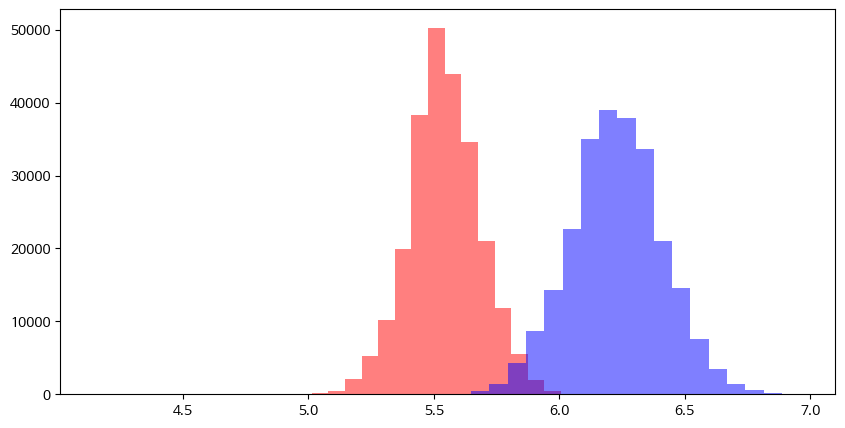

In [100]:
from scipy import stats
group1 = house.loc[house['팩스번호_유무'] == 0, 'target']
group2 = house.loc[house['팩스번호_유무'] == 1, 'target']

group1 = np.random.choice(group1, len(group2), replace=False)

print("팩스번호가 없을 때의 집값 평균과 중앙값: ", np.mean(group1), np.median(group1))
print("팩스번호가 있을 때의 집값 평균과 중앙값: ", np.mean(group2), np.median(group2))

sns.kdeplot(group1, label='팩스번호 없음', color='red')
sns.kdeplot(group2, label='팩스번호 있음', color='blue')
plt.legend()
plt.show()


# 정규분포로 변환
group1_normal, fitted_lambda1 = stats.boxcox(group1)
group2_normal, fitted_lambda2 = stats.boxcox(group2)

plt.figure(figsize=(10, 5))
plt.hist(group1_normal, bins=30, color='red', label='팩스번호 없음', alpha=0.5)
plt.hist(group2_normal, bins=30, color='blue', label='팩스번호 있음', alpha=0.5)



# t_stat, p_value = stats.ttest_ind(group1, group2)
# print(f"t-statistic: {t_stat:.4f}")
# print(f"p-value: {p_value:.7f}")

# # p-value가 0.05보다 작으면 통계적으로 유의미한 차이가 있다고 볼 수 있습니다
# if p_value < 0.05:
#     print("통계적으로 유의미한 차이가 있습니다.")
# else:
#     print("통계적으로 유의미한 차이가 없습니다.")

확실히 팩스번호 유무에 따라서 집값 분포가 차이가 난다는 것을 확인할 수 있다. 팩스번호를 유무 column으로 대체하는 것이 좋을 것 같다.

##### ~~t-검정을 통한 두 그룹 간 분포 차이 검정~~

In [101]:
# p_values = []
# for _ in range(1000):
#     sample1 = np.random.choice(group1, 50, replace=False)
#     sample2 = np.random.choice(group2, 50, replace=False)
#     t_stat, p = stats.ttest_ind(sample1, sample2, equal_var=False)
#     p_values.append(p)

# print(np.mean(np.array(p_values)))

In [102]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy import stats
# from scipy.stats.mstats import winsorize


# def test_normality(group1, group2):
#     # Shapiro-Wilk 검정 수행
#     stat1, p1 = stats.shapiro(group1)
#     stat2, p2 = stats.shapiro(group2)
    
#     print(f"1번 그룹 - Shapiro-Wilk 검정:")
#     print(f"통계량: {stat1:.4f}, p-value: {p1:.4f}")
    
#     print(f"2번 그룹 - Shapiro-Wilk 검정:")
#     print(f"통계량: {stat2:.4f}, p-value: {p2:.4f}")
  

# def test_equal_variance(group1, group2):
#     # Levene's test 수행
#     stat, p_value = stats.levene(group1, group2)
    
#     print(f"Levene's test:")
#     print(f"통계량: {stat:.4f}")
#     print(f"p-value: {p_value:.4f}")
    
#     if p_value < 0.05:
#         print("귀무가설 기각: 두 그룹의 분산이 동일하지 않습니다.")
#     else:
#         print("귀무가설 채택: 두 그룹의 분산이 동일합니다.")

# print(np.min(group1), np.max(group1))
# print(np.min(group2), np.max(group2))
    
# transformed_data1, fitted_lambda1 = stats.boxcox(group1)
# transformed_data2, fitted_lambda2 = stats.boxcox(group2)
# data_winsor1 = winsorize(transformed_data1, limits=[0.05, 0.05])
# data_winsor2 = winsorize(transformed_data2, limits=[0.05, 0.05])
# print(f"fitted_lambda1: {fitted_lambda1}")
# print(f"fitted_lambda2: {fitted_lambda2}")
# sns.boxplot(data_winsor1)
# plt.show()
# sns.boxplot(data_winsor2)
# plt.show()

# test_normality(data_winsor1, data_winsor2)
# test_equal_variance(data_winsor1, data_winsor2)

### 단지 분류에 따른 집값 확인

#### 요약:

In [9]:
col_list = list(house.columns)
print(col_list)
find_idx = col_list.index('단지분류(아파트,주상복합등등)')
print(find_idx)
col_list[find_idx] = '단지분류'
house.columns = col_list

['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', '등기신청일자', '거래유형', '중개사소재지', '단지분류(아파트,주상복합등등)', '전화번호', '팩스번호', '세대타입(분양형태)', '관리방식', '복도유형', '난방방식', '전체동수', '전체세대수', '건설사(시공사)', '시행사', '사용검사일-사용승인일', '연면적', '주거전용면적', '관리비부과면적', '전용면적별세대현황(60㎡이하)', '전용면적별세대현황(60㎡~85㎡이하)', '85㎡~135㎡이하', '135㎡초과', '홈페이지', '수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target']
14


In [ ]:
display(house['단지분류'].value_counts())

house_group = house.groupby('단지분류')['target'].mean().reset_index()
display(house_group)



아파트               235994
주상복합               11360
도시형 생활주택(주상복합)       500
도시형 생활주택(아파트)        152
연립주택                 125
Name: 단지분류, dtype: int64

,단지분류,target
0,도시형 생활주택(아파트),15959.276316
1,도시형 생활주택(주상복합),20274.454000
2,아파트,68669.849971
3,연립주택,98934.400000
4,주상복합,66270.891285


In [24]:
print(house['아파트명'].unique())

['개포6차우성' '개포우성3차' '개포자이' ... '807-39' '밀란체' '신용산빌딩']


In [25]:
print(house[house['아파트명'] == '밀란체'])

                   시군구      번지     본번    부번 아파트명   전용면적    계약년월  계약일  층  건축년도  \
1109620  서울특별시 송파구 석촌동  227-12  227.0  12.0  밀란체  68.36  200705   25  6  2007   

         ... 건축면적 주차대수 기타/의무/임대/임의=1/2/3/4 단지승인일 사용허가여부 관리비 업로드 좌표X 좌표Y 단지신청일  \
1109620  ...  NaN  NaN                 NaN   NaN    NaN     NaN NaN NaN   NaN   

        target  
1109620  31000  

[1 rows x 49 columns]


In [20]:
# 아파트명 별로 그룹화 한 다음 단지 분류가 하나라도 있는 그룹은 그 값으로 대체
print(len(house['아파트명'].unique()))
house_group = house.groupby('아파트명')['단지분류'].apply(lambda x: x.value_counts(dropna=False))
display(house_group)






6539


아파트명         
153-25    NaN      3
201호 미공시  NaN      1
2차한양      NaN    438
3RU-City  NaN     66
3차신성미소지움  NaN     83
                ... 
힐탑트레져1동   NaN     43
힐튼        NaN     18
힐튼빌리지1차   NaN     13
힐튼빌리지2차   NaN     14
힐하우스      NaN     24
Name: 단지분류, Length: 6591, dtype: int64

### 다음 변수

# 모델 돌려보기


## 1. Data preprocessing


In [3]:
# train/test 구분을 위한 column
house_train['is_test'] = 0
house_test['is_test'] = 1
concat = pd.concat([house_train, house_test])

In [4]:
# 살릴 column들 정리
use_cols = np.array(['전용면적(㎡)', '계약년월', '층', '번지', '본번', '부번',
'k-전체세대수', 'k-연면적', '주차대수', '좌표X', '좌표Y', 'target', 
'시군구', '아파트명', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식',
'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-홈페이지', 'k-전화번호', 'k-팩스번호',
'경비비관리형태', '세대전기계약방법', '청소비관리형태',
'기타/의무/임대/임의=1/2/3/4', '사용허가여부', 'is_test'
])

concat = concat[use_cols]

In [5]:
# 본번, 부번 문자열로 변환
concat['본번'] = concat['본번'].astype(str)
concat['부번'] = concat['부번'].astype(str)
numeric_features = concat.select_dtypes(include=[np.number]).columns
categorical_features = concat.select_dtypes(include=[np.object]).columns

cols = list(concat.columns)
print(cols)
cols[0] = '전용면적'

#열들 중에 앞에 "k-"가 붙은 열들은 "k-" 제거
cols = [col.replace('k-', '') for col in cols]
concat.columns = cols

['전용면적(㎡)', '계약년월', '층', '번지', '본번', '부번', 'k-전체세대수', 'k-연면적', '주차대수', '좌표X', '좌표Y', 'target', '시군구', '아파트명', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-홈페이지', 'k-전화번호', 'k-팩스번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '사용허가여부', 'is_test']


In [6]:
# # 65이하, 65이상 85이하, 85이상 135이하, 135이상 변수를 크기1, 크기2, 크기3, 크기4로 변환
# concat_cols = list(concat.columns)
# idx = concat_cols.index('전용면적별세대현황(60㎡이하)')
# concat_cols[idx:idx+4] = ['크기1', '크기2', '크기3', '크기4']
# idx = concat_cols.index('단지분류(아파트,주상복합등등)')
# concat_cols[idx] = '단지분류'
# concat.columns = concat_cols


# concat[['크기1', '크기2', '크기3', '크기4']] = concat[['크기1', '크기2', '크기3', '크기4']].fillna(0)


In [7]:
# concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
# concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
# concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)


In [8]:
# # Null값이 100만개 이상인 칼럼은 삭제해보도록 하겠습니다.
# print('* 결측치가 100만개 이하인 변수들 :', list(concat.columns[concat.isnull().sum() <= 1000000]))     # 남겨질 변수들은 아래와 같습니다.
# print('* 결측치가 100만개 이상인 변수들 :', list(concat.columns[concat.isnull().sum() >= 1000000]))

In [9]:
# # 필요없는 변수 제거
# selected = list(concat.columns[concat.isnull().sum() <= 1000000])
# selected.append('홈페이지')
# selected.remove('건축면적')

# # unselected = list(concat.columns[concat.isnull().sum() >= 1000000])
# # unselected.remove('홈페이지')
# # print(unselected)
# concat = concat[selected]



### 구에 따른 target encoding

In [10]:
# 시군구 column을 구와 동 변수로 분할
concat['구'] = concat['시군구'].str.split(' ').str[1]
concat['동'] = concat['시군구'].str.split(' ').str[2]

concat_encode = concat[concat['is_test'] == 0][['구', 'target']]
concat_encode = concat_encode.groupby('구')['target'].mean().reset_index()
concat_encode.columns = ['구', '구_target']

# 구_target MinMaxScaler
scaler = MinMaxScaler()
concat_encode['구_target'] = scaler.fit_transform(concat_encode[['구_target']])
print(concat_encode['구_target'])

# 구 변수를 통해 concat과 concat_encode 병합
concat_encoded = pd.merge(concat, concat_encode, on='구', how='left')

# 구 변수 drop
concat_encoded = concat_encoded.drop(columns=['구'])
display(concat_encoded)


0     1.000000
1     0.271074
2     0.077088
3     0.148220
4     0.120950
5     0.424898
6     0.080562
7     0.021522
8     0.023466
9     0.000000
10    0.160030
11    0.349865
12    0.392179
13    0.206915
14    0.985061
15    0.446195
16    0.159102
17    0.626407
18    0.327021
19    0.291991
20    0.891821
21    0.142266
22    0.310523
23    0.363716
24    0.039448
Name: 구_target, dtype: float64


,전용면적,계약년월,층,번지,본번,부번,전체세대수,연면적,주차대수,좌표X,...,전화번호,팩스번호,경비비관리형태,세대전기계약방법,청소비관리형태,기타/의무/임대/임의=1/2/3/4,사용허가여부,is_test,동,구_target
0,79.97,201712,3,658-1,658.0,1.0,270.0,22637.0,262.0,127.05721,...,025776611,025776673,직영,단일계약,직영,임의,Y,0,개포동,1.000000
1,79.97,201712,4,658-1,658.0,1.0,270.0,22637.0,262.0,127.05721,...,025776611,025776673,직영,단일계약,직영,임의,Y,0,개포동,1.000000
2,54.98,201712,5,658-1,658.0,1.0,270.0,22637.0,262.0,127.05721,...,025776611,025776673,직영,단일계약,직영,임의,Y,0,개포동,1.000000
3,79.97,201801,4,658-1,658.0,1.0,270.0,22637.0,262.0,127.05721,...,025776611,025776673,직영,단일계약,직영,임의,Y,0,개포동,1.000000
4,79.97,201801,2,658-1,658.0,1.0,270.0,22637.0,262.0,127.05721,...,025776611,025776673,직영,단일계약,직영,임의,Y,0,개포동,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,84.65,202307,13,816,816.0,0.0,1402.0,190866.0,1568.0,127.10672,...,024969683,024969685,위탁,종합계약,위탁,의무,Y,1,신내동,0.039448
1128090,84.62,202307,12,816,816.0,0.0,1402.0,190866.0,1568.0,127.10672,...,024969683,024969685,위탁,종합계약,위탁,의무,Y,1,신내동,0.039448
1128091,101.65,202308,12,816,816.0,0.0,1402.0,190866.0,1568.0,127.10672,...,024969683,024969685,위탁,종합계약,위탁,의무,Y,1,신내동,0.039448
1128092,84.94,202309,18,816,816.0,0.0,1402.0,190866.0,1568.0,127.10672,...,024969683,024969685,위탁,종합계약,위탁,의무,Y,1,신내동,0.039448


In [11]:
display(concat_encoded.columns)

Index(['전용면적', '계약년월', '층', '번지', '본번', '부번', '전체세대수', '연면적', '주차대수', '좌표X',
       '좌표Y', 'target', '시군구', '아파트명', '단지분류(아파트,주상복합등등)', '세대타입(분양형태)',
       '관리방식', '복도유형', '난방방식', '건설사(시공사)', '시행사', '홈페이지', '전화번호', '팩스번호',
       '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '사용허가여부',
       'is_test', '동', '구_target'],
      dtype='object')

In [12]:
df = concat_encoded.drop(columns=['시군구', '번지','본번', '부번'])

### 이상치 처리

In [13]:
def remove_outliers_iqr(dt, column_name):
    df = dt.query('is_test == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
    df_test = dt.query('is_test == 1')

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    result = pd.concat([df, df_test])   # test data와 다시 합쳐주겠습니다.
    return result

In [14]:
df = remove_outliers_iqr(df, '전용면적')

### 범주형, 연속형 보간


In [15]:
numeric_features = df.select_dtypes(include=[np.number]).columns
categorical_features = df.select_dtypes(include=[np.object]).columns

print(numeric_features)
print(categorical_features)

Index(['전용면적', '계약년월', '층', '전체세대수', '연면적', '주차대수', '좌표X', '좌표Y', 'target',
       'is_test', '구_target'],
      dtype='object')
Index(['아파트명', '단지분류(아파트,주상복합등등)', '세대타입(분양형태)', '관리방식', '복도유형', '난방방식',
       '건설사(시공사)', '시행사', '홈페이지', '전화번호', '팩스번호', '경비비관리형태', '세대전기계약방법',
       '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '사용허가여부', '동'],
      dtype='object')


In [16]:
# 범주형 변수에 대한 보간
df[categorical_features] = df[categorical_features].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
df[numeric_features] = df[numeric_features].interpolate(method='linear', axis=0)

## feature engineering

### 전화번호 혹은 팩스번호 유무 column 생성

In [17]:
# 전화번호 혹은 팩스번호가 있다면 1, 없다면 0으로 변환
df['번호_유무'] = df[['전화번호', '팩스번호']].notnull().any(axis=1).astype(int)

#전화번호, 팩스번호 변수 drop
df = df.drop(columns=['전화번호', '팩스번호'])
display(df)


,전용면적,계약년월,층,전체세대수,연면적,주차대수,좌표X,좌표Y,target,아파트명,...,홈페이지,경비비관리형태,세대전기계약방법,청소비관리형태,기타/의무/임대/임의=1/2/3/4,사용허가여부,is_test,동,구_target,번호_유무
0,79.97,201712,3,270.0,22637.0,262.0,127.05721,37.476763,124000.0,개포6차우성,...,NULL,직영,단일계약,직영,임의,Y,0,개포동,1.000000,1
1,79.97,201712,4,270.0,22637.0,262.0,127.05721,37.476763,123500.0,개포6차우성,...,NULL,직영,단일계약,직영,임의,Y,0,개포동,1.000000,1
2,54.98,201712,5,270.0,22637.0,262.0,127.05721,37.476763,91500.0,개포6차우성,...,NULL,직영,단일계약,직영,임의,Y,0,개포동,1.000000,1
3,79.97,201801,4,270.0,22637.0,262.0,127.05721,37.476763,130000.0,개포6차우성,...,NULL,직영,단일계약,직영,임의,Y,0,개포동,1.000000,1
4,79.97,201801,2,270.0,22637.0,262.0,127.05721,37.476763,117000.0,개포6차우성,...,NULL,직영,단일계약,직영,임의,Y,0,개포동,1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,84.65,202307,13,1402.0,190866.0,1568.0,127.10672,37.618870,13250.0,신내우디안1단지,...,NULL,위탁,종합계약,위탁,의무,Y,1,신내동,0.039448,1
1128090,84.62,202307,12,1402.0,190866.0,1568.0,127.10672,37.618870,13250.0,신내우디안1단지,...,NULL,위탁,종합계약,위탁,의무,Y,1,신내동,0.039448,1
1128091,101.65,202308,12,1402.0,190866.0,1568.0,127.10672,37.618870,13250.0,신내우디안1단지,...,NULL,위탁,종합계약,위탁,의무,Y,1,신내동,0.039448,1
1128092,84.94,202309,18,1402.0,190866.0,1568.0,127.10672,37.618870,13250.0,신내우디안1단지,...,NULL,위탁,종합계약,위탁,의무,Y,1,신내동,0.039448,1


# OpenAPI를 이용한 merge를 통해 결측치 처리

In [18]:
# house_sub = pd.read_csv('apartment_info_selected.csv')

# #아파트명을 기준으로 합치기
# merge_df = concat_encoded.merge(house_sub, on='아파트명', how='left', suffixes=('', '_sub'))


In [19]:
# selected_colunms = {
#   'CMPX_CLSF': '단지분류',
#   'MNG_MTHD': '관리방식',
#   'ROAD_TYPE': '복도유형',
#   'MN_MTHD': '난방방식',
#   'WHOL_DONG_CNT': '전체동수',
#   'TNOHSH': '전체세대수',
#   'BLDR': '건설사(시공사)',
#   'DVLR': '시행사',
#   'GFA': '연면적',
#   'RSDT_XUAR': '주거전용면적',
#   'MNCO_LEVY_AREA': '관리비부과면적',
#   'XUAR_HH_STTS60': '크기1',
#   'XUAR_HH_STTS85': '크기2',
#   'XUAR_HH_STTS135': '크기3',
#   'XUAR_HH_STTS136': '크기4',
#   'HMPG': '홈페이지',
# }

# fill_cols = list(selected_colunms.values())
# for col in fill_cols:
#     merge_df[col] = merge_df[col].combine_first(merge_df[f'{col}_sub'])

In [20]:
# drop_cols = [i+'_sub' for i in fill_cols]
# merge_df = merge_df.drop(columns=drop_cols)

# display(merge_df)


# Model Traning

In [21]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = df.query('is_test==0')
dt_test = df.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1029574, 26) (9272, 26)


In [22]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

## 범주형 변수 Label Encoding

In [23]:
numeric_features = df.select_dtypes(include=[np.number]).columns
categorical_features = df.select_dtypes(include=[np.object]).columns

In [24]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_features ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

100%|██████████| 15/15 [00:03<00:00,  4.89it/s]


## Model Traning

In [25]:
assert dt_train.shape[1] == dt_test.shape[1]  

In [26]:
#랜덤시드 설정
random_seed = 2023

# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [27]:
# # RandomForestRegressor를 이용해 회귀 모델을 적합시키겠습니다.
# model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
# model.fit(X_train, y_train)
# pred = model.predict(X_val)

In [28]:
import lightgbm as lgb


# 특성 이름 정리
feature_names = [str(f).replace(' ', '_').replace('(', '').replace(')', '').replace('[', '').replace(']', '').replace('{', '').replace('}', '').replace(':', '').replace(',', '') for f in X_train.columns]

params = {
    'objective': 'regression',         # 회귀 문제일 경우
    'metric': 'rmse',                  # 평가 지표 (MSE 또는 RMSE 많이 사용)
    'boosting_type': 'gbdt',           # 기본 부스팅 방식
    'learning_rate': 0.05,             # 학습률
    'num_leaves': 31,                  # 트리 최대 잎 개수 (너무 크면 과적합 위험)
    'max_depth': -1,                   # 트리 최대 깊이 (-1이면 제한 없음)
    'feature_fraction': 0.9,           # 각 트리마다 사용할 피처 비율
    'bagging_fraction': 0.8,           # 각 트리마다 사용할 데이터 샘플 비율
    'bagging_freq': 5,                 # bagging 수행 빈도 (5번에 한 번씩)
    'verbose': -1,                     # 로그 최소화
    'seed': 42,                        # 재현을 위한 시드 고정
    'bagging_seed': 42,
    'feature_fraction_seed': 42,
    'data_random_seed': 42,
    'drop_seed': 42
}

# LightGBM 데이터셋 생성
lgb_train = lgb.Dataset(X_train, label=y_train, feature_name=feature_names)
lgb_eval = lgb.Dataset(X_val, label=y_val, feature_name=feature_names, reference=lgb_train)

# 모델 학습
print("모델 학습 중...")
model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_eval],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

모델 학습 중...
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 13072.6
[200]	valid_0's rmse: 11387.6
[300]	valid_0's rmse: 10485.6
[400]	valid_0's rmse: 9903.52
[500]	valid_0's rmse: 9494.26
[600]	valid_0's rmse: 9172.22
[700]	valid_0's rmse: 8872.02
[800]	valid_0's rmse: 8620.98
[900]	valid_0's rmse: 8423.38
[1000]	valid_0's rmse: 8223.4
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 8223.4


In [29]:
# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

NameError: name 'pred' is not defined

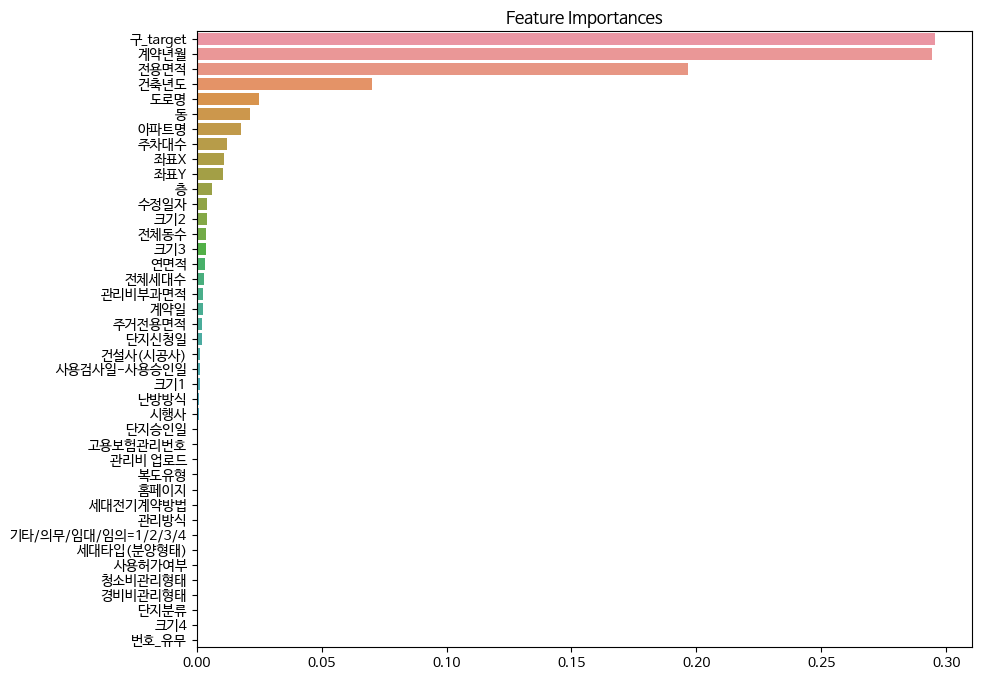

In [36]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [38]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(model,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = 'neg_mean_squared_error',        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())    # valid data에 대해 적합시킵니다.

Weight,Feature
965534826.9911 ± 1772155.4884,구_target
895576518.8853 ± 9905294.4208,계약년월
533314724.4906 ± 3918846.1221,전용면적
255125965.2200 ± 1622543.2559,건축년도
89526005.6800 ± 2310889.8046,도로명
74644640.7160 ± 1037767.2586,동
61498292.3490 ± 721083.5019,아파트명
25361881.6110 ± 585844.5869,좌표Y
24918230.7831 ± 204133.7826,좌표X
14565156.4003 ± 200623.4076,주차대수


## Valid prediction 분석

In [40]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred

In [41]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

In [42]:
# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting

In [43]:
X_val_sort.head(10)

,아파트명,전용면적,계약년월,계약일,층,건축년도,도로명,단지분류,세대타입(분양형태),관리방식,...,좌표X,좌표Y,단지신청일,홈페이지,동,구_target,번호_유무,target,pred,error
232753,2080,107.47,202201,11,1,1973,5026,0,0,0,...,127.015875,37.600886,249,4,111,0.985061,1,287000.0,537200.0,6.260004e+10
224608,4766,91.68,202206,27,3,2017,2220,0,0,0,...,126.960858,37.487309,249,4,281,1.000000,1,117562.0,347300.0,5.277955e+10
240000,200,79.47,202107,17,9,1974,5248,0,0,0,...,127.050021,37.495560,249,4,179,1.000000,1,81500.0,229600.0,2.193361e+10
239100,1257,121.74,202012,19,2,2005,4420,0,0,0,...,127.059827,37.496981,249,4,59,1.000000,1,355000.0,209400.0,2.119936e+10
423713,3571,78.50,201902,18,8,2018,6688,0,0,0,...,127.054938,37.555603,249,4,256,0.985061,1,109258.0,252800.0,2.060431e+10
58002,5327,122.10,201803,10,2,1982,5031,0,0,0,...,127.012465,37.494466,249,4,111,0.985061,1,350000.0,206600.0,2.056356e+10
391818,835,122.44,201812,20,2,2006,3706,0,0,0,...,127.052626,37.494096,249,4,45,1.000000,1,90000.0,218800.0,1.658944e+10
1331,835,122.44,201808,31,4,2006,3706,0,0,0,...,127.058659,37.494389,249,4,45,1.000000,1,86500.0,213800.0,1.620529e+10
239630,2455,115.89,202104,29,2,2003,3716,0,0,0,...,127.055013,37.496284,249,4,137,1.000000,1,75000.0,199040.0,1.538592e+10
274602,1290,84.91,202108,20,1,2002,5040,0,0,0,...,127.007970,37.510694,249,4,256,0.985061,1,104500.0,224600.0,1.442401e+10


In [44]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)       # 예측을 잘한 top 100개의 data

In [46]:
# 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
error_top100 = X_val_sort_top100.copy()
for column in categorical_features :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_features :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [47]:
display(error_top100.head(10))
display(best_top100.head(10))

,아파트명,전용면적,계약년월,계약일,층,건축년도,도로명,단지분류,세대타입(분양형태),관리방식,...,좌표X,좌표Y,단지신청일,홈페이지,동,구_target,번호_유무,target,pred,error
232753,반포주공1단지,107.47,202201,11,1,1973,신반포로 45,NULL,NULL,NULL,...,127.015875,37.600886,NULL,NULL,반포동,0.985061,1,287000.0,537200.0,6.260004e+10
224608,청담디에브스,91.68,202206,27,3,2017,도산대로92길 28,NULL,NULL,NULL,...,126.960858,37.487309,NULL,NULL,청담동,1.000000,1,117562.0,347300.0,5.277955e+10
240000,강남상가,79.47,202107,17,9,1974,압구정로2길 46,NULL,NULL,NULL,...,127.050021,37.495560,NULL,NULL,신사동,1.000000,1,81500.0,229600.0,2.193361e+10
239100,동부센트레빌,121.74,202012,19,2,2005,선릉로 206,NULL,NULL,NULL,...,127.059827,37.496981,NULL,NULL,대치동,1.000000,1,355000.0,209400.0,2.119936e+10
423713,아크로리버뷰신반포,78.50,201902,18,8,2018,잠원로 117,NULL,NULL,NULL,...,127.054938,37.555603,NULL,NULL,잠원동,0.985061,1,109258.0,252800.0,2.060431e+10
58002,한신15차,122.10,201803,10,2,1982,신반포로15길 5,NULL,NULL,NULL,...,127.012465,37.494466,NULL,NULL,반포동,0.985061,1,350000.0,206600.0,2.056356e+10
391818,논현프라임,122.44,201812,20,2,2006,봉은사로11길 11,NULL,NULL,NULL,...,127.052626,37.494096,NULL,NULL,논현동,1.000000,1,90000.0,218800.0,1.658944e+10
1331,논현프라임,122.44,201808,31,4,2006,봉은사로11길 11,NULL,NULL,NULL,...,127.058659,37.494389,NULL,NULL,논현동,1.000000,1,86500.0,213800.0,1.620529e+10
239630,삼성동드림하우스,115.89,202104,29,2,2003,봉은사로71길 19,NULL,NULL,NULL,...,127.055013,37.496284,NULL,NULL,삼성동,1.000000,1,75000.0,199040.0,1.538592e+10
274602,동아,84.91,202108,20,1,2002,신반포로33길 15,NULL,NULL,NULL,...,127.007970,37.510694,NULL,NULL,잠원동,0.985061,1,104500.0,224600.0,1.442401e+10


,아파트명,전용면적,계약년월,계약일,층,건축년도,도로명,단지분류,세대타입(분양형태),관리방식,...,좌표X,좌표Y,단지신청일,홈페이지,동,구_target,번호_유무,target,pred,error
399223,래미안트리베라1단지,59.600,201909,26,4,2010,삼양로19길 25,NULL,NULL,NULL,...,126.846996,37.555331,NULL,NULL,미아동,0.077088,1,57500.0,57500.0,0.0
790069,상계주공10,59.390,201312,20,11,1988,노원로 564,NULL,NULL,NULL,...,127.053741,37.683095,NULL,NULL,상계동,0.023466,1,23000.0,23000.0,0.0
359922,서울숲리버뷰자이,84.960,202006,18,19,2018,고산자로2길 65,아파트,기타,위탁관리,...,127.038323,37.554285,2018-07-04 19:37:28.0,riverviewxi.com,행당동,0.446195,1,153000.0,153000.0,0.0
978181,영화아이닉스,84.980,201004,4,14,2005,개봉로1길 188,NULL,NULL,NULL,...,126.857320,37.505901,NULL,NULL,개봉동,0.080562,1,31200.0,31200.0,0.0
886128,신반포2,107.310,201211,14,12,1978,신반포로23길 41,NULL,NULL,NULL,...,127.030812,37.543890,NULL,NULL,잠원동,0.985061,1,99800.0,99800.0,0.0
315622,앰팰리스,73.133,202006,10,7,2020,신림로 194,NULL,NULL,NULL,...,127.064226,37.544182,NULL,NULL,신림동,0.120950,1,53580.0,53580.0,0.0
456546,대우,84.930,201702,8,3,2000,삼양로149길 45,NULL,NULL,NULL,...,126.850775,37.555037,NULL,NULL,우이동,0.077088,1,40000.0,40000.0,0.0
748401,한신공영,115.070,201502,17,11,1996,영등포로12길 7,NULL,NULL,NULL,...,126.920142,37.518540,NULL,NULL,양평동1가,0.291991,1,47000.0,47000.0,0.0
272624,반포주공1단지,106.250,202102,2,5,1973,신반포로 45,NULL,NULL,NULL,...,126.993315,37.504834,NULL,NULL,반포동,0.985061,1,440000.0,440000.0,0.0
303799,천호동삼성,59.860,201910,8,10,1997,성안로25길 15,NULL,NULL,NULL,...,127.024675,37.613379,NULL,NULL,천호동,0.271074,1,54500.0,54500.0,0.0


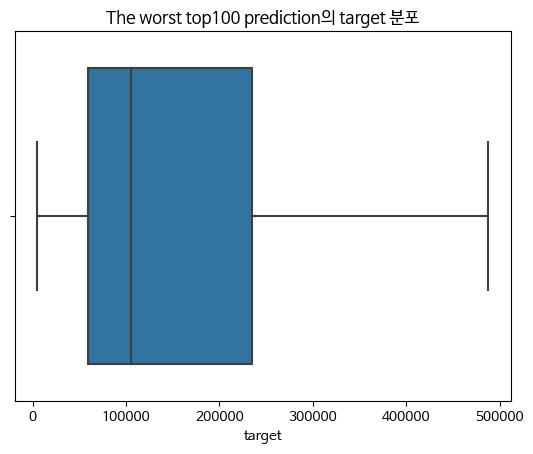

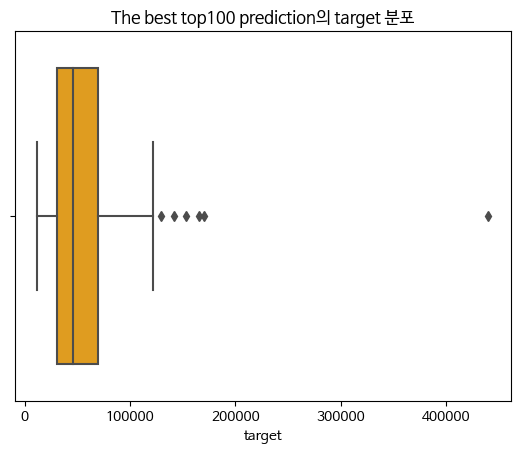

In [48]:
sns.boxplot(data = error_top100, x='target')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.boxplot(data = best_top100, x='target', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

## 모델 저장

In [61]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Inference

In [30]:
# with open('saved_model.pkl', 'rb') as f:
#     model = pickle.load(f)

X_test = dt_test.drop(['target'], axis=1)
# 예측을 진행합니다.
pred = model.predict(X_test)

# 예측 결과를 저장합니다.
X_test['pred'] = pred

In [63]:
pred.shape

(9272,)

In [31]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(pred.astype(int), columns=["target"])
preds_df.to_csv('output_origin.csv', index=False)